# Install Required libraries

Install the below package and restart the kernel inorder to apply the updated packages

In [ ]:
#!pip install accelerate -U

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [101]:
data = pd.read_csv('data/gamedev.csv')
data.head(2)

,id,user_id,tags,question,answer
0,7544,4450,"['pause', 'timescale']",How can I pause my game?,"In the Editor, you can just click the pause bu..."
1,7544,4450,"['pause', 'timescale']",What is the best way to pause my game?,"In the Editor, you can just click the pause bu..."


## Load pre-trained Bert Model

In [102]:
# check for null values
data.isnull().sum()

id          0
user_id     0
tags        0
question    0
answer      9
dtype: int64

In [103]:
# remove null value rows
data = data.dropna()

# check for null values
data.isnull().sum()

id          0
user_id     0
tags        0
question    0
answer      0
dtype: int64

# Exploratory Data Analysis

In [104]:
print(" Number of questions associated with each tag\n", data['tags'].value_counts())

print("\n---------------------------------------------------------------------------\n")
# Unique answers in the dataset

print("Length of the dataset: ", len(data))
print("\n Total number of unique answers in the dataset: ", len(data['answer'].unique()))
print(" Number of unique answers in the dataset: \n", data['answer'].unique())


 Number of questions associated with each tag
 []                                                                    2674
['c#']                                                                1787
['scripting problem']                                                  581
['animation']                                                          566
['unity 5']                                                            385
                                                                      ... 
['editor', 'serialization', 'collections']                               2
['webrequest', 'encoding']                                               1
['error', 'array', 'list', 'gameobject.find', 'unexpected-symbol']       1
['c#', 'pathfinding', 'offset', 'astar', 'nodes']                        1
['get', 'compare']                                                       1
Name: tags, Length: 10041, dtype: int64

---------------------------------------------------------------------------

Length of 

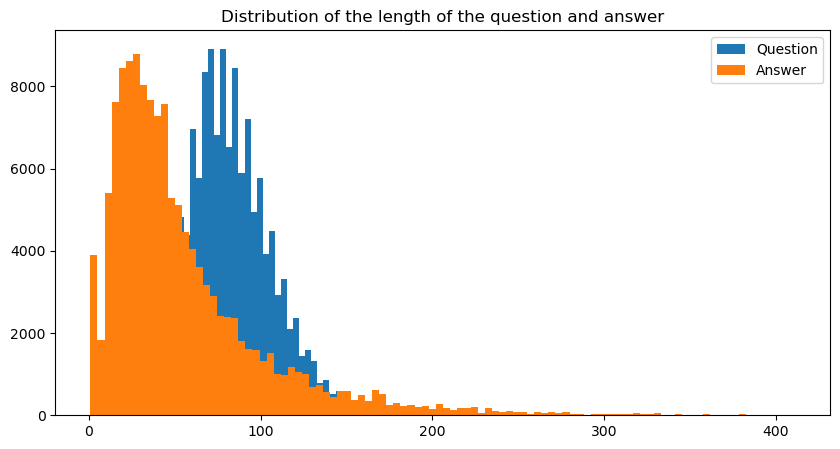

In [105]:
# plot the distribution of the length of the question and answer
plt.figure(figsize=(10, 5))
plt.hist(data['question'].str.len(), bins=100, label='Question')
plt.hist(data['answer'].str.len(), bins=100, label='Answer')
plt.title('Distribution of the length of the question and answer')
plt.legend()
plt.show()

(-0.5, 799.5, 499.5, -0.5)

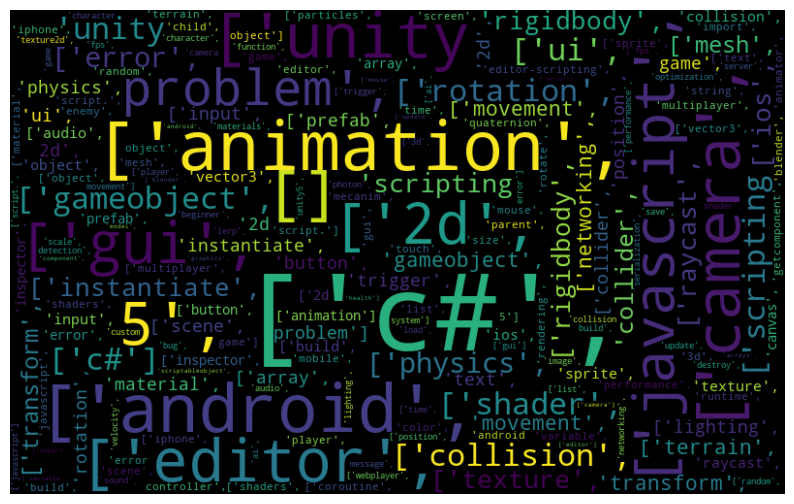

In [106]:
# count word frequency

def wordcloud(col):
    word_freq = {}
    for sent in data[col]:
        for word in sent.split():
            if word not in word_freq:
                word_freq[word] = 0
            word_freq[word] += 1
    return word_freq

word_freq = wordcloud('tags') # if want to check for question col replace 'tags' with 'question'
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')


In [107]:
labels = data['answer'].unique().tolist()
labels = [str(s).strip() for s in labels]
labels

['In the Editor, you can just click the pause button.',
 'Log into Apple\'s developer portal and click the "iTunes Connect" link in the sidebar.',
 'You can attach the debugger to the editor process or the running built debug exe.',
 "To attempt to solve the editor crash, create a folder in a separate location where you can move files and directories you've moved or created within the project folder since the last time Unity ran successfully.",
 'Set the time of AnimationState of the relevant clip in the Update function.',
 'Vamos',
 'You can use the SharpUSBLib to access USB applications through Unity.',
 'CharacterController',
 'Keep your allocations small, and if you allocate a large buffer consider re-using it instead of destroying it (for instance, wiping out a large matrix of values and using the same one, instead of re-allocating different sizes across iterations).',
 'Make it inactive.',
 '1. Compressing images 2. Compressing JavaScript and CSS 3. Caching data 4. Streamlining s

In [108]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

**Prepare** **FAQ** Data

In [109]:
id2label

{0: 'In the Editor, you can just click the pause button.',
 1: 'Log into Apple\'s developer portal and click the "iTunes Connect" link in the sidebar.',
 2: 'You can attach the debugger to the editor process or the running built debug exe.',
 3: "To attempt to solve the editor crash, create a folder in a separate location where you can move files and directories you've moved or created within the project folder since the last time Unity ran successfully.",
 4: 'Set the time of AnimationState of the relevant clip in the Update function.',
 5: 'Vamos',
 6: 'You can use the SharpUSBLib to access USB applications through Unity.',
 7: 'CharacterController',
 8: 'Keep your allocations small, and if you allocate a large buffer consider re-using it instead of destroying it (for instance, wiping out a large matrix of values and using the same one, instead of re-allocating different sizes across iterations).',
 9: 'Make it inactive.',
 10: '1. Compressing images 2. Compressing JavaScript and CSS

In [110]:
label2id

{'In the Editor, you can just click the pause button.': 0,
 'Log into Apple\'s developer portal and click the "iTunes Connect" link in the sidebar.': 1,
 'You can attach the debugger to the editor process or the running built debug exe.': 2,
 "To attempt to solve the editor crash, create a folder in a separate location where you can move files and directories you've moved or created within the project folder since the last time Unity ran successfully.": 3,
 'Set the time of AnimationState of the relevant clip in the Update function.': 4,
 'Vamos': 5,
 'You can use the SharpUSBLib to access USB applications through Unity.': 6,
 'CharacterController': 7,
 'Keep your allocations small, and if you allocate a large buffer consider re-using it instead of destroying it (for instance, wiping out a large matrix of values and using the same one, instead of re-allocating different sizes across iterations).': 8,
 'Make it inactive.': 9,
 '1. Compressing images 2. Compressing JavaScript and CSS 3. 

In [111]:
data['labels'] = data['answer'].map(lambda x: label2id[str(x).strip()] if isinstance(x, str) else None)
data.head()

,id,user_id,tags,question,answer,labels
0,7544,4450,"['pause', 'timescale']",How can I pause my game?,"In the Editor, you can just click the pause bu...",0
1,7544,4450,"['pause', 'timescale']",What is the best way to pause my game?,"In the Editor, you can just click the pause bu...",0
2,7544,4450,"['pause', 'timescale']","When I play a game, how do I pause it?","In the Editor, you can just click the pause bu...",0
3,7544,4450,"['pause', 'timescale']",Could you please tell me how I can pause my game?,"In the Editor, you can just click the pause bu...",0
4,7544,4450,"['pause', 'timescale']","In order to pause my game, what should I do?","In the Editor, you can just click the pause bu...",0


In [112]:
X = list(data['question'])[:5000]
X[:5]

# print only questions and answers


['How can I pause my game?',
 'What is the best way to pause my game?',
 'When I play a game, how do I pause it?',
 'Could you please tell me how I can pause my game?',
 'In order to pause my game, what should I do?']

In [113]:
y = list(data['labels'])[:5000]
y[:5]

[0, 0, 0, 0, 0]

In [114]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 123)

# Built Data Loader

In [115]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [116]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

full_data = tokenizer(X, truncation=True, padding=True)

In [117]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):

        return len(self.labels)

## Training Arguments

In [118]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [119]:
fullDataLoader = DataLoader(full_data, y_test)

In [120]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [121]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=15, #100
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [122]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [123]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,9.321700,8.997870,0.001000,0.000096,0.000052,0.000602
100,8.221900,7.245450,0.005000,0.000024,0.000012,0.002421
150,6.734400,6.413376,0.006000,0.001640,0.002434,0.003632
200,6.257700,6.147666,0.019000,0.004258,0.005321,0.008011
250,6.013200,5.909734,0.027000,0.004286,0.003288,0.013527
300,5.739100,5.653738,0.055000,0.039989,0.039010,0.053462
350,5.469200,5.366273,0.146000,0.156072,0.162775,0.171256
400,5.146000,5.051255,0.268000,0.288261,0.298540,0.307114
450,4.850000,4.742774,0.413000,0.452082,0.468696,0.474841
500,4.537900,4.452226,0.563000,0.606582,0.621173,0.623206


TrainOutput(global_step=945, training_loss=4.967917806635458, metrics={'train_runtime': 304.0367, 'train_samples_per_second': 197.345, 'train_steps_per_second': 3.108, 'total_flos': 1976389259040000.0, 'train_loss': 4.967917806635458, 'epoch': 15.0})

In [127]:
q = [trainer.evaluate(eval_dataset=data) for data in (train_dataloader, test_dataloader)]

pd.DataFrame(q, index=['train', 'test']).iloc[:, :5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,4.202644,0.698,0.663994,0.704463,0.665338
test,4.452226,0.563,0.606582,0.621173,0.623206


In [128]:
def predict(text):
    
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [129]:
text = "How to make a game?"
predict(text)

(tensor([[2.6690e-03, 1.4602e-03, 1.6699e-03,  ..., 1.7890e-05, 1.4129e-05,
          1.4420e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(323, device='cuda:0'),
 'Start with the first, follow just what he does, and then try to experiment and edit things later.')